## Final Project Code

This is a uncompleted version. We need to implement 
1. Parameter Setup
2. ODE Model
3. ODE Solver (using basic julia ODESolve)
4. Interpretation Simulation

Package use

In [5]:
using Plots, LinearAlgebra, OrdinaryDiffEq,DiffEqBase

In [3]:
### helper function ###

## Pnm
function calculatePnm(y)
    Pnm = 0
    for i = 2:16
        Pnm += y[i]
    end
    return Pnm
end
   
function a_genes(y)
    return y[2]+y[6]+y[7] + y[8] + y[12]+y[13]+y[14]
end

## define a(y) function
function a(y)
    P = calculatePnm(y)
    if (y[2]/P) > 0.1
        return 0
    else
        return 1
    end
end

a (generic function with 1 method)

In [33]:
#################################
####### Input parameters ########
#################################

k1 = 10^(-7)
k2 = 10^(-4)
k3 = 10^(-9)
kmut = 10^(-5)
b   = 10.
br = 9.92
d = 10.
dD = 10.11

y1 = 10. ^8
################################

################################
yvec = [y1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
kvec = [k1 k1 k1 k2 k1 k1 k2 k1 k2 k1 k2 k2 k1 k2 k2 k3 0] #M cells will not mutate by assumption

bvec = [1/b 1/b 1/b 1/b 1/br 1/b 1/b 1/br 1/b 1/br 1/br 1/b 1/br 1/br 1/br 1/br 1/br]
dvec = [1/d 1/d 1/dD 1/d 1/d 1/dD 1/d 1/d 1/dD 1/dD 1/d 1/dD 1/dD 1/d 1/dD 1/dD 1/dD]

S_act = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
         0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
         0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
         0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0;
         0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0;
         0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0;
         0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0;
         0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0;
         0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0;
         0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0;
         0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0;
         0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0;
         0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0;
         0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0;
         0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0;
         0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0;
         0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

#################################################################
# M matrix is pain in the ass to understand
# Mij corresponds to y[i] to y[j] when i neq j
# Mii is the amounts it leaves from y[i]
# e.g. for M1,2 corresponds to 100 since 100 genes go from N to A
#################################################################
## Note that below Mii didn't change since its a long calculation and left below
##   N    A    D    G    R    AD    AG    AR    DG    DR    GR    ADG    ADR    AGR    DGR    T    M
M0= [-464 100  100  100  100  10    10    10    10    10    10    1      1      1      1      0    0;#N
     0   -331  0    0    0    100   100   100   0     0     0     10     10     10     0      1    0;#A
     0    0   -331  0    0    100   0     0     100   100   0     10     10     0      10     1    0;#D
     0    0    0   -331  0    0     100   0     100   0     100   10     0      10     10     1    0;#G
     0    0    0    0   -331  0     0     100   0     100   100   0      10     10     10     1    0;#R
     0    0    0    0    0   -210   0     0     0     0     0     100    100    0      0      10   0;#AD
     0    0    0    0    0    0   -210    0     0     0     0     100    0      100    0      10   0;#AG
     0    0    0    0    0    0     0    -210   0     0     0     0      100    100    0      10   0;#AR
     0    0    0    0    0    0     0     0    -210   0     0     100    0      0      100    10   0;#DG
     0    0    0    0    0    0     0     0     0   -210    0     0      100    0      100    10   0;#DR
     0    0    0    0    0    0     0     0     0     0   -210    0      0      100    100    10   0;#GR
     0    0    0    0    0    0     0     0     0     0     0    -100    0      0      0      100  0;#ADG
     0    0    0    0    0    0     0     0     0     0     0     0     -100    0      0      100  0;#ADR
     0    0    0    0    0    0     0     0     0     0     0     0      0    -100     0      100  0;#AGR
     0    0    0    0    0    0     0     0     0     0     0     0      0      0     -100    100  0;#DGR
     0    0    0    0    0    0     0     0     0     0     0     0      0      0      0      0    0;#T
     0    0    0    0    0    0     0     0     0     0     0     0      0      0      0      0    0]#M
#Calculate Mii
varinfo()

| name    |        size | summary                                                                                                                  |
|:------- | -----------:|:------------------------------------------------------------------------------------------------------------------------ |
| Base    |             | Module                                                                                                                   |
| Core    |             | Module                                                                                                                   |
| M0      |   2.297 KiB | 17×17 Array{Int64,2}                                                                                                     |
| Main    |             | Module                                                                                                                   |
| S_act   |   2.297 KiB | 17×17 Array{Int64,2}                                                                                                     |
| T       |     8 bytes | Int64                                                                                                                    |
| b       |     8 bytes | Float64                                                                                                                  |
| br      |     8 bytes | Float64                                                                                                                  |
| bvec    |   176 bytes | 1×17 Array{Float64,2}                                                                                                    |
| d       |     8 bytes | Float64                                                                                                                  |
| dD      |     8 bytes | Float64                                                                                                                  |
| dvec    |   176 bytes | 1×17 Array{Float64,2}                                                                                                    |
| k1      |     8 bytes | Float64                                                                                                                  |
| k2      |     8 bytes | Float64                                                                                                                  |
| k3      |     8 bytes | Float64                                                                                                                  |
| kmut    |     8 bytes | Float64                                                                                                                  |
| kvec    |   176 bytes | 1×17 Array{Float64,2}                                                                                                    |
| ode     |   5.391 KiB | ODEProblem with uType Array{Float64,2} and tType Float64. In-place: true                                                 |
| osol    | 250.555 KiB | VectorOfArray{Float64,3}                                                                                                 |
| params  |   5.148 KiB | NamedTuple{(:k, :b, :M, :d, :S),Tuple{Array{Float64,2},Array{Float64,2},Array{Int64,2},Array{Float64,2},Array{Int64,2}}} |
| system! |     0 bytes | typeof(system!)                                                                                                          |
| y1      |     8 bytes | Float64                                                                                                                  |
| yvec    |   176 bytes | 1×17 Array{Float64,2}                                                                                                    |


In [137]:
### system of ODE
function system!(dy,y,p,t)
    k = p.k
#    b = p.b
    M = p.M
#    d = p.d
    S = p.S

    Pnm = y[2] +y[3] +y[4] +y[5] +y[6] +y[7] +y[8] +y[9] +y[10] +y[11] +y[12] +y[13] +y[14] +y[15] +y[16]
#    mm = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 (-10^(-9)*y[16]) (10^(-9)*y[16] + (1/br - 1/dD)*y[17])]
#    dy .= (diag(diag(y'*k)*b)' * M + (diag((b-d)'*y))')*S*(1-Pnm/(10^6))*(1-Pnm/10^(13))+mm
#
#    Pnm = calculatePnm(y)
    dy[1] = 0;      # y1: N 
    dy[2] = (100*k1*y[1]/b+(1/b-1/d)*y[2]-331*k1*y[2]/b) *(1 - Pnm/10^13)                                                            #y2: A
    dy[3] =  ((100* k1* y[1])/b + (1/b - 1/dD)*y[3] - (331* k1*y[3])/b)*(1 - Pnm/10^13)                                  # y3: D
    dy[4] = ((100*k1*y[1])/b + (1/b - 1/d)* y[4] - (331*k2 *y[4])/b)*(1 - Pnm/10^13)                                                                # y4: G
    dy[5] = ((100* k1* y[1])/b + (1/br - 1/d)* y[5] - (331* k1* y[5])/br) *(1 - Pnm/10^13)                                 # y5: R
    dy[6] = ((10*k1 *y[1])/b + (100* k1* y[2])/b + (100* k1* y[3])/b + (1/b - 1/dD)* y[6] - (210*k1* y[6])/b)*(1 - Pnm/10^13)                     # y6: AD
    dy[7] = ((10* k1* y[1])/b + (100*k1* y[2])/b + (100* k2* y[4])/b + (1/b - 1/d)* y[7] - (210* k2* y[7])/b) *(1 - Pnm/10^13)                                            # y7: AG
    dy[8] = ((10* k1* y[1])/b + (100* k1* y[2])/b + (100* k1* y[5])/br + (1/br - 1/d)* y[8] - (210* k1* y[8])/br) *(1 - Pnm/10^13)                   # y8: AR
    dy[9] = ((10*k1* y[1])/b + (100*k1* y[3])/b + (100* k2* y[4])/b + (1/b - 1/dD) *y[9] - (210* k2* y[9])/b) *(1 - Pnm/10^13)                  # y9: DG
    dy[10] = ((10*k1*y[1])/b + (1/br - 1/dD)*y[10] - (210* k1* y[10])/br + (100 *k1* y[3])/b + (100* k1* y[5])/br) *(1 - Pnm/10^13)               # y10: DR
    dy[11] = ((10* k1* y[1])/b + (1/br - 1/d)* y[11] - (210* k2* y[11])/br + (100* k2* y[4])/b + (100 * k1* y[5])/br) *(1 - Pnm/10^13)       # y11: GR
    dy[12] = ((k1*y[1])/b + (1/b - 1/dD)* y[12] - (100* k2* y[12])/b + (10* k1* y[2])/b + (10*k1* y[3])/b + (10* k2* y[4])/b + (100* k1* y[6])/b + (100* k2* y[7])/b + (100 *k2* y[9])/b) *(1 - Pnm/10^13)         # y12: ADG
    dy[13] = ((k1*y[1])/b + (100 *k1* y[10])/br + (1/br - 1/dD) *y[13] - (100* k1* y[13])/br + (10* k1* y[2])/b + (10 *k1* y[3])/b + (10 *k1* y[5])/br + (100* k1 *y[6])/b + (100* k1* y[8])/br) *(1 - Pnm/10^13)   # y13: ADR
    dy[14] = ((k1 *y[1])/b + (100* k2* y[11])/br + (1/br - 1/d)* y[14] - (100* k2* y[14])/br + (10 *k1* y[2])/b + (10* k2* y[4])/b + (10 *k1* y[5])/br + (100 *k2* y[7])/b + (100* k1* y[8])/br) * (1 - Pnm/(10^13))   # y14: AGR
    dy[15] = ((k1* y[1])/b + (100* k1* y[10])/br + (100 *k2* y[11])/br + (1/br - 1/dD)* y[15] - (100 *k2* y[15])/br + (10 *k1* y[3])/b + (10 *k2* y[4])/b + (10* k1* y[5])/br + (100* k2* y[9])/b) *(1 - Pnm/10^13)    # y15: DGR
    dy[16] = ((10* k1* y[10])/br + (10 *k2* y[11])/br + (100 *k2* y[12])/b + (100 *k1* y[13])/br + (100 *k2* y[14])/br + (100 *k2* y[15])/br + (1/br - 1/dD)* y[16] + (k1*y[2])/b + (k1* y[3])/b + (k2 *y[4])/b + (k1* y[5])/br + (10* k1* y[6])/b + (10* k2 *y[7])/b + (10* k1* y[8])/br + (10 *k2* y[9])/b )*(1 - Pnm/10^13)   # y16: T primary tumor cells
    dy[17] = (k3 * y[16]+y[17]*(1/br - 1/dD))      # y17: M metastatic cells

    nothing
end


system! (generic function with 1 method)

In [138]:
### Solve ODE
params = (
    k = kvec,
    b = bvec,
    M = M0,
    d = dvec,
    S = S_act
)
T = 365*100
ode = ODEProblem(system!,yvec, (0.0,T), params)
osol  = solve(ode, Tsit5(),abstol=1e-4,reltol=1e-5)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 163-element Array{Float64,1}:
     0.0
     0.028985981469376334
     0.3188457961631396
     3.2174439431007724
    11.812054459816826
    24.895787124450493
    41.31646618667682
    62.78744013747516
    89.30472683011202
   121.99298212646659
   161.26059676628427
   207.9041672594664
   262.4543904623585
     ⋮
 33716.329779748914
 33983.95126962393
 34251.57273114076
 34519.194217471006
 34786.81567544306
 35054.43715822854
 35322.05861265583
 35589.68009189653
 35857.301542779045
 36124.923018474976
 36392.544483536585
 36500.0
u: 163-element Array{Array{Float64,2},1}:
 [1.0e8 0.0 … 0.0 0.0]
 [1.0e8 2.89859800788472 … 2.9542890474391527e-6 2.8543467078666034e-17]
 [1.0e8 31.884562790916792 … 0.00035809398935995293 3.8046393806567405e-14]
 [1.0e8 321.74268104514425 … 0.03710208315316398 3.9661133731986086e-11]
 [1.0e8 1181.1823546318822 … 0.5259066038477493 2.046897163725735e-9]
 [1.0e8 2489.47613688238

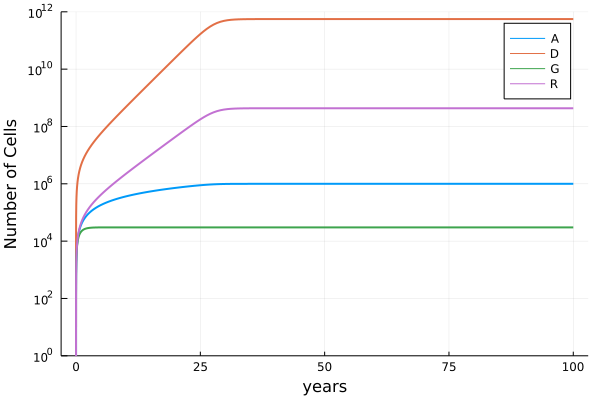

In [57]:
plot(osol.t/365, [a[2] for a in osol.u],lw=2,xlabel="years",label="A",ylabel="Number of Cells",ylims=(1e0,1e12),yscale=:log10)
plot!(osol.t/365, [a[3] for a in osol.u],lw=2,xlabel="years",label="D",ylabel="Number of Cells")
plot!(osol.t/365, [a[4] for a in osol.u],lw=2,xlabel="years",label="G",ylabel="Number of Cells")
plot!(osol.t/365, [a[5] for a in osol.u],lw=2,xlabel="years",label="R",ylabel="Number of Cells")


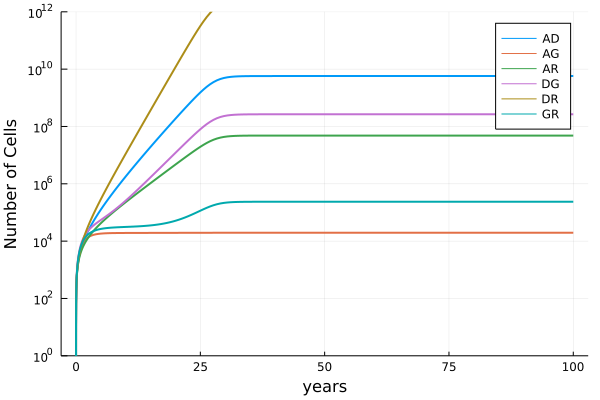

In [58]:
plot(osol.t/365, [a[6] for a in osol.u],lw=2,xlabel="years",label="AD",ylabel="Number of Cells",ylims=(1e0,1e12),yscale=:log10)
plot!(osol.t/365, [a[7] for a in osol.u], lw=2,label="AG")
plot!(osol.t/365, [a[8] for a in osol.u],lw=2,label="AR")
plot!(osol.t/365, [a[9] for a in osol.u],lw=2,label="DG")
plot!(osol.t/365, [a[10] for a in osol.u],lw=2,label="DR")
plot!(osol.t/365, [a[11] for a in osol.u],lw=2,label="GR")


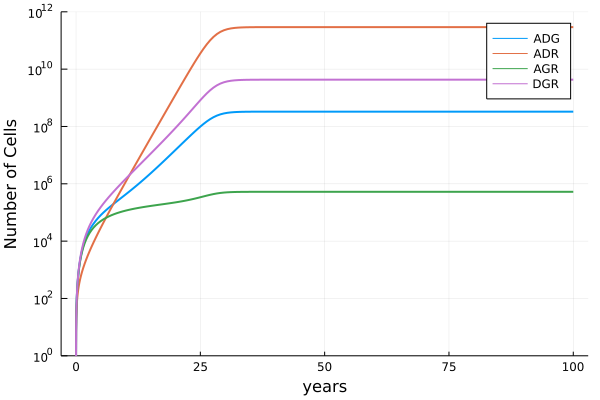

In [59]:
plot(osol.t/365, [a[12] for a in osol.u],lw=2,xlabel="years",label="ADG",ylabel="Number of Cells",ylims=(1e0,1e12),yscale=:log10)
plot!(osol.t/365, [a[13] for a in osol.u], lw=2,label="ADR")
plot!(osol.t/365, [a[14] for a in osol.u],lw=2,label="AGR")
plot!(osol.t/365, [a[15] for a in osol.u],lw=2,label="DGR")

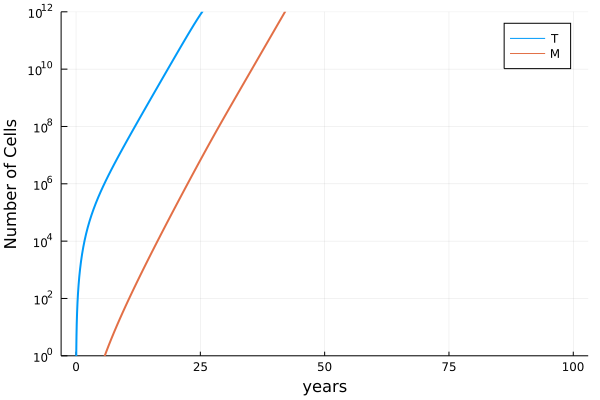

In [60]:
plot(osol.t/365, [a[16] for a in osol.u],lw=2,xlabel="years",label="T",ylabel="Number of Cells",ylims=(1e0,1e12),yscale=:log10)
plot!(osol.t/365, [a[17] for a in osol.u],lw=2,xlabel="years",label="M",ylabel="Number of Cells")

In [139]:
## get column
i=1
for a in osol.u
    if a[16]>1e9
        print("e9 ", i,"\n")
    end
    
    if a[16]>1e12
        print("e12 ", i, "\n")
    end 
    
    if a[17]>1e12
        print("e12y ", i, "\n")
    end
    i = i+1
end

e9 44
e9 45
e9 46
e9 47
e9 48
e9 49
e9 50
e9 51
e9 52
e9 53
e9 54
e9 55
e9 56
e9 57
e9 58
e9 59
e9 60
e9 61
e12 61
e9 62
e12 62
e9 63
e12 63
e9 64
e12 64
e9 65
e12 65
e9 66
e12 66
e9 67
e12 67
e9 68
e12 68
e9 69
e12 69
e9 70
e12 70
e9 71
e12 71
e9 72
e12 72
e9 73
e12 73
e9 74
e12 74
e9 75
e12 75
e9 76
e12 76
e9 77
e12 77
e9 78
e12 78
e9 79
e12 79
e9 80
e12 80
e9 81
e12 81
e9 82
e12 82
e9 83
e12 83
e9 84
e12 84
e12y 84
e9 85
e12 85
e12y 85
e9 86
e12 86
e12y 86
e9 87
e12 87
e12y 87
e9 88
e12 88
e12y 88
e9 89
e12 89
e12y 89
e9 90
e12 90
e12y 90
e9 91
e12 91
e12y 91
e9 92
e12 92
e12y 92
e9 93
e12 93
e12y 93
e9 94
e12 94
e12y 94
e9 95
e12 95
e12y 95
e9 96
e12 96
e12y 96
e9 97
e12 97
e12y 97
e9 98
e12 98
e12y 98
e9 99
e12 99
e12y 99
e9 100
e12 100
e12y 100
e9 101
e12 101
e12y 101
e9 102
e12 102
e12y 102
e9 103
e12 103
e12y 103
e9 104
e12 104
e12y 104
e9 105
e12 105
e12y 105
e9 106
e12 106
e12y 106
e9 107
e12 107
e12y 107
e9 108
e12 108
e12y 108
e9 109
e12 109
e12y 109
e9 110
e12 110
e12y 110

In [140]:
osol.t[44]

5746.949628973383

In [141]:
osol.t[61]

9539.707862007772

In [142]:
osol.t[84]

15520.221766797838

In [146]:
import Pkg; 
Pkg.add("StatsPlots")
using StatsPlots
NmutT9 = 5746.949628973383
NmutT12 = 9539.707862007772
NmutM = 15520.221766797838
N = [NmutT9, NmutT12, NmutM] ./365
AmutT9 = 5649.564265979429
AmutT12 = 9437.302443675038
AmutM = 15407.254542092858
A = [AmutT9, AmutT12, AmutM] ./365
DmutT9 = 5570.661152563691
DmutT12 = 9357.948541821492
DmutTM = 15346.511155247836
D = [DmutT9,DmutT12,DmutTM ] ./365
GmutT9 = 3496.2904968242633
GmutT12 = 7146.6877468867115
GmutM = 13604.037623390666
G = [GmutT9,GmutT12,GmutM] ./365
RmutT9 = 5606.534037576784
RmutT10 = 9392.364060369515
RmutM = 15370.347680649922
R = [RmutT9,RmutT10,RmutM] ./365

ctg = repeat(["10^9 Tumor cell", "10^12 Tumor Cell", "10^12 Metastatic Cell"], outer = 5)
nam = repeat(["N","A", "D", "G", "R"], inner = 3)
data = [N;
        A;
        D;
        G;
        R]

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


15-element Array{Float64,1}:
 15.745067476639406
 26.136185923308965
 42.52115552547353
 15.478258262957342
 25.855623133356268
 42.21165627970646
 15.262085349489563
 25.63821518307258
 42.04523604177489
  9.578878073491133
 19.579966429826605
 37.27133595449498
 15.360367226237763
 25.732504274984972
 42.110541590821704

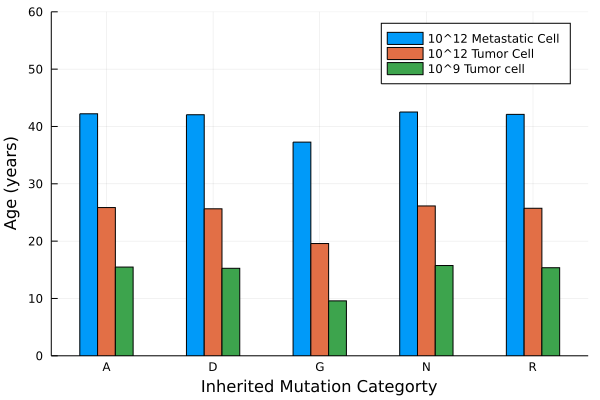

In [149]:
groupedbar(nam,data,group = ctg, ylims=(0,60), xlabel="Inherited Mutation Categorty", ylabel="Age (years)",
    bar_width = 0.5)